In [25]:
!pip install rustworkx

In [26]:
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt
import cvxpy as cp

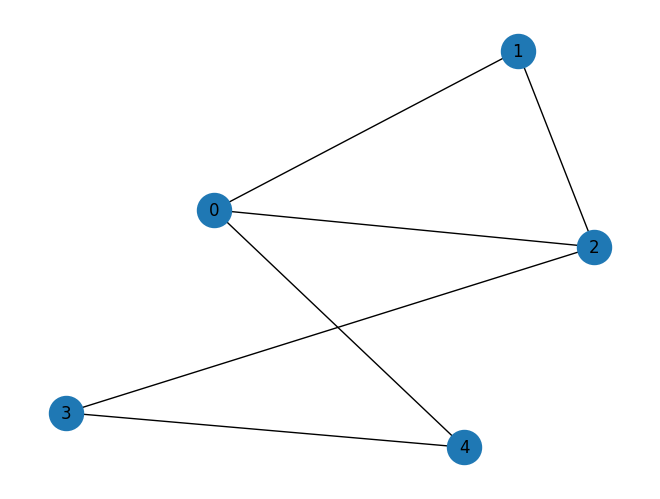

In [35]:
n = 5
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(n))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
mpl_draw(graph, node_size=600, with_labels=True)

In [36]:
A = rx.graph_adjacency_matrix(graph)
print(A)

[[0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]


In [37]:
X = cp.Variable((n, n), symmetric=True)
constraints = [X >> 0]
for i in range(n):
    constraints.append(X[i, i] == 1)

objective = cp.Maximize(0.25 * cp.sum(cp.multiply(A, (1 - X))))
problem = cp.Problem(objective, constraints)
problem.solve()

np.float64(5.18549243862834)

In [38]:
def sdp_rounding_rx(X_opt, graph, num_trials=500):
    best_cut = 0
    best_partition = None
    n = X_opt.shape[0]
    jitter = 1e-5
    try:
        L = np.linalg.cholesky(X_opt + jitter * np.eye(n))
        V = L.T
    except np.linalg.LinAlgError:
        eigvals, eigvecs = np.linalg.eigh(X_opt)
        V = np.diag(np.sqrt(np.maximum(eigvals, 0))) @ eigvecs.T
    for _ in range(num_trials):
        r = np.random.randn(n)
        r /= np.linalg.norm(r)
        partition = np.sign(V @ r)
        partition[partition == 0] = 1
        cut_value = 0
        for i, j in graph.edge_list():
            if partition[i] != partition[j]:
                cut_value += 1
        if cut_value > best_cut:
            best_cut = cut_value
            best_partition = partition
    return best_cut, best_partition

In [31]:
X_opt = X.value
cut_value, partition = sdp_rounding_rx(X_opt, graph)

print(f"SDP Optimal Value (Upper Bound): {problem.value:.4f}")
print(f"Best Rounded Cut Value found: {cut_value}")

SDP Optimal Value (Upper Bound): 5.1855
Best Rounded Cut Value found: 5


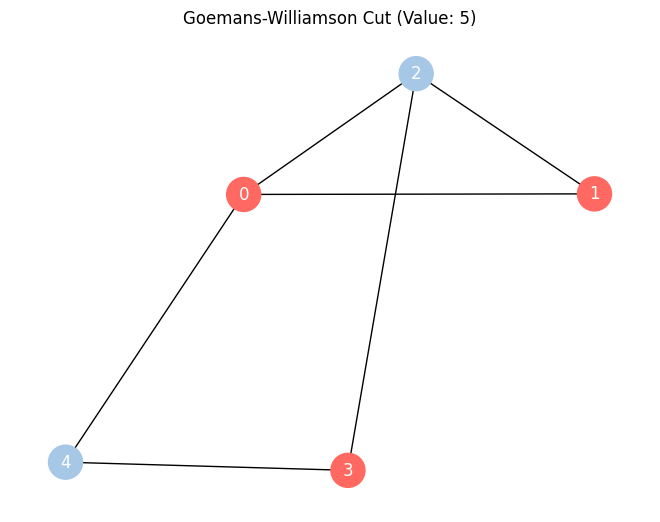

In [32]:
colors = ['#FF6961' if partition[i] > 0 else '#A7C7E7' for i in range(n)]

mpl_draw(
    graph,
    with_labels=True,
    node_color=colors,
    node_size=600,
    font_color='white'
)
plt.title(f"Goemans-Williamson Cut (Value: {cut_value})")
plt.show()